# Porous Electrode FiPy model

Troubleshooting of model presented by [@JDS19](https://github.com/JDS19) in [usnistgov/fipy#788](https://github.com/usnistgov/fipy/issues/788)

Based on Newman, J., & Tiedemann, W. (1974). POROUS-ELECTRODE THEORY WITH BATTERY APPLICATIONS. *Lawrence Berkeley National Laboratory. LBNL Report #: LBL-3117*. Retrieved from https://escholarship.org/uc/item/9vd6z2g7.

In [3]:
%matplotlib inline

In [18]:
from fipy import Variable, FaceVariable, CellVariable, Grid1D, TransientTerm, DiffusionTerm, Viewer
from fipy import ImplicitSourceTerm, ConvectionTerm, ResidualTerm
from fipy.tools import numerix
from builtins import range

$a$, $i0$, $F$,$D$,$\phi_1$,$z_1$,$ct$,$R$,$T$, $c_1^0$, and $c_2^0$ are constants
$\phi_2$, $c_1$, and $c_2$ are time-dependent, time-evolving variables to solve for. In the problem, $z_2$ is 0 which simplifies the flux and exponent terms for $c_2$.

In [5]:
phi_0 = 0.0 # arbitrarily set to 0
phi_app = 0.2 # Applied voltage 
c1_0 = 0.1 # M  
c2_0 = 0.1 # M
z1 = -1.0
z2 = 0.
phi_1 = phi_0 + phi_app/2 
L = .25 # cm of electrode thickness 
por = 0.4 # porosoity 
D = 5e-5 # diffusion coefficient, cm^2/s
a = 360. #cm^2 per cm^3, specific interfacial area for GFD2.5
ct,R,F,T = 0.5, 8.3143, 96487., 293.
ne, s = 1, 1
i0 = 0.005 # from Exchange Current Densities 

Evolve in time on a 1D mesh

In [31]:
# New code
nx = 100
dx = L/nx
mesh = Grid1D(nx=nx,dx=dx)
x = mesh.cellCenters[0]
dt = .01
#dt = 0.5*dx**2/(2*D)
steps = 100
t = dt * steps
time = Variable(0.)

$\phi_2$, $c_1$, and $c_2$ are time-dependent, time-evolving variables to solve for.

In [32]:
phi2 = CellVariable(name="phi2",mesh=mesh,hasOld=True)
c1 =  CellVariable(name="c1",mesh=mesh,hasOld=True)
c2 =  CellVariable(name="c2",mesh=mesh,hasOld=True)
phi2.setValue(phi_0)
c1.setValue(c1_0)
c2.setValue(c2_0)

For simplicity, start with 0 flux boundary conditions on the bounds of x on [0,L].
The initial conditions are:

$ c_1(0,0) = c_1(L,0) = 0.1 $

$ c_2(0,0) = c_2(L,0) = 0. $

$ \phi_2 (0,0) = \phi_2 (L,0) = \phi_0 $

In [33]:
c1.constrain(c1_0, where=mesh.exteriorFaces)
c2.constrain(0., where=mesh.exteriorFaces)
phi2.constrain(phi_0, where=mesh.exteriorFaces)

# # No flux at x=0, dc2/dx = 0 automatically
# # Flux for c1 has concentration & potential gradient
# # Set up Robin BC;
# # unsure about this set up; folllowed this website:
# # https://www.ctcms.nist.gov/fipy/documentation/
# #USAGE.html#applying-robin-boundary-conditions

# #Make point to apply Robin BC, where x=0
# mask = (x=0.)
# # Create values to put into equation for phi2
# phi_a = FaceVariable(mesh=mesh,rank=1)
# phi_a.setValue(-2.,where=mask)
# phi_b = FaceVariable(mesh=mesh,rank=0)
# phi_b.setValue(1.,where=mask)
# phi_g =  FaceVariable(mesh=mesh,rank=0)
# phi_g.setValue(-2.0*(phi_1+phi_0),where=mask)

# # Repeat for c1 whose concentration gradient 
# # cancels the migration gradient
# c1_a = FaceVariable(mesh=mesh,rank=1)
# c1_a.setValue(-1.,where=mask)
# c1_b = FaceVariable(mesh=mesh,rank=0)
# c1_b.setValue(1.,where=mask)

# c1.faceGrad.constrain(0,mesh.facesRight)
# phi2.faceGrad.constrain(0,mesh.facesRight)

# # No gradients at x = L
# c1.faceGrad.constrain(0,mesh.facesRight)
# c2.faceGrad.constrain(0,mesh.facesRight)
# phi2.faceGrad.constrain(0,mesh.facesRight)

Equations for material balance and charge neutrality are

\\[ \frac{\partial c_1}{\partial t} = -\nabla\cdot N_1 - \nabla\cdot i/F \\]

\\[ \frac{\partial c_2}{\partial t} = -\nabla\cdot N_2 + \nabla\cdot i/F \\]

\\[ \sum{z_i \nabla\cdot N_i} = \nabla\cdot i/F \\]

where

\\[ N_i = -D \nabla c_i - \frac{D F}{R T} z_i c_i \nabla \phi_2 \\]

and

\\[ \nabla\cdot i = a i0/por(c_1/c_1^0 e^{z_1 ct F/(RT)(\phi_1 - \phi_2 - \phi_0)} - c_2/c_2^0 e^{z_2 ct F/(RT)(\phi_1 - \phi_2 - \phi_0)}) \\]

We define combinations of constants

$\beta \equiv ct F/(R T)$

$u \equiv D F / (R T)$

$bv \equiv a i0/(F por)$

In [34]:
# Constants in equations
beta = ct*F/R/T # For exponential
mig = D*F/R/T # in front of migration term
bv = a*i0/F/por # in front of Faradaic reaction

Apply the chain rule to isolate terms in each solution variable, allowing better coupling and implicitness:

$-\nabla \cdot N_i \equiv \nabla \cdot (D \nabla c_i) + \nabla \cdot (u z_i c_i \nabla \phi_2)$

such that

\\[ \frac{\partial c_1}{\partial t} = \nabla\cdot (D \nabla c_1) + \nabla\cdot(u z_1 c_1 \nabla \phi_2) 
- c_1 (bv / c_1^0) e^{z_1 \beta (\phi_1 - \phi_2 - \phi_0)} + c_2 (bv / c_2^0) \\]

Note that the Faradaic term is not implicit in $\phi_2$, but it is implicit in $c_1$ and $c_2$.

In [83]:
faradaic1 = (bv/c1_0)*numerix.exp(z1*beta*(phi_1-phi2-phi_0))
faradaic2 = bv/c2_0

In [84]:
# Equation for first species
eq1 = (TransientTerm(var=c1) == DiffusionTerm(coeff=D,var=c1) 
    # Migration effect (is this OK??)
    + DiffusionTerm(coeff=c1*z1*mig,var=phi2)
    # subtract Faradaic term
    - ImplicitSourceTerm(coeff=faradaic1, var=c1)
    + ImplicitSourceTerm(coeff=faradaic2, var=c2))

\\[ \frac{\partial c_2}{\partial t} = \nabla\cdot (D \nabla c_2) 
+ c_1 (bv / c_1^0) e^{z_1 \beta (\phi_1 - \phi_2 - \phi_0)} - c_2 (bv / c_2^0) \\]

In [85]:
# Equation for second species
eq2 = (TransientTerm(var=c2) == DiffusionTerm(coeff=D,var=c2)
    + ImplicitSourceTerm(coeff=faradaic1, var=c1)
    - ImplicitSourceTerm(coeff=faradaic2, var=c2))

$ \nabla\cdot (z_1 D \nabla c_1) + \nabla\cdot(u z_1^2 c_1 \nabla \phi_2)
+ c_1 (bv / c_1^0) e^{z_1 \beta (\phi_1 - \phi_2 - \phi_0)} - c_2 (bv / c_2^0) = 0 $

In [86]:
# Equation relating flux to current for electrolyte potential
eq3 = (DiffusionTerm(coeff=c1*mig*z1**2,var=phi2)
    # Add diffusion
    # + D*z1*c1.faceGrad.divergence <- don't use this?
    # + DiffusionTerm(coeff=z1*D*c1,var=None) <- don't use!
    + DiffusionTerm(coeff=z1*D,var=c1)
    # Add Faradaic contributions, 
    # can't use ImplicitSourceTerm because it's nonlinear in phi
    + ImplicitSourceTerm(coeff=faradaic1, var=c1)
    - ImplicitSourceTerm(coeff=faradaic2, var=c2))

Following this [notebook demonstrating Newton-Raphson iterations](https://gist.github.com/guyer/f29c759fd7f0f01363b8483c7bc644cb), solve for variations in the solution variables $\delta c_1$, $\delta c_2$, and $\delta \phi_2$.

In [87]:
# Need to do Newton steps
deltaC1 = CellVariable(mesh=mesh,name="delta C1",hasOld=True)
deltaC2 = CellVariable(mesh=mesh,name="delta C2",hasOld=True)
deltaPhi2 = CellVariable(mesh=mesh,name="delta Phi2",hasOld=True)

$ \frac{\partial \delta c_1}{\partial t} = \nabla\cdot (D \nabla \delta c_1) + \nabla\cdot(u z_1 \delta c_1 \nabla \phi_2) + \nabla\cdot(u z_1 c_1 \nabla \delta \phi_2) 
- \delta c_1 (bv / c_1^0) e^{z_1 \beta (\phi_1 - \phi_2 - \phi_0)} 
- \delta \phi_2 z_1 \beta c_1 (bv / c_1^0) e^{z_1 \beta (\phi_1 - \phi_2 - \phi_0)}
+ \delta c_2 (bv / c_2^0) $

In [88]:
newton_eqC1 = ((TransientTerm(var=deltaC1)
            == DiffusionTerm(coeff=D, var=deltaC1) 
            + ConvectionTerm(coeff=z1*mig*phi2.faceGrad,var=deltaC1)
            + DiffusionTerm(coeff=z1*mig*c1,var=deltaPhi2)
            # subtract Faradaic term
            - ImplicitSourceTerm(coeff=faradaic1, var=deltaC1)
            - ImplicitSourceTerm(coeff=z1 * beta * c1 * faradaic1, var=deltaPhi2)
            + ImplicitSourceTerm(coeff=faradaic2, var=deltaC2))
            + ResidualTerm(equation=eq1))

$ \frac{\partial \delta c_2}{\partial t} = \nabla\cdot (D \nabla \delta c_2) 
+ \delta c_1 (bv / c_1^0) e^{z_1 \beta (\phi_1 - \phi_2 - \phi_0)}
+ \delta \phi_2 z_1 \beta c_1 (bv / c_1^0) e^{z_1 \beta (\phi_1 - \phi_2 - \phi_0)}
- \delta c_2 (bv / c_2^0) $

In [89]:
newton_eqC2 = ((TransientTerm(var=deltaC2)
            == DiffusionTerm(coeff=D,var=deltaC2) 
            # subtract Faradaic term
            + ImplicitSourceTerm(coeff=faradaic1, var=deltaC1)
            + ImplicitSourceTerm(coeff=z1 * beta * c1 * faradaic1, var=deltaPhi2)
            - ImplicitSourceTerm(coeff=faradaic2, var=deltaC2))
            + ResidualTerm(equation=eq2) )

$ \nabla\cdot (z_1 D \nabla \delta c_1) + \nabla\cdot(u z_1^2 \delta c_1 \nabla \phi_2)
+ \nabla\cdot(u z_1^2 c_1 \nabla \delta \phi_2)
+ \delta c_1 (bv / c_1^0) e^{z_1 \beta (\phi_1 - \phi_2 - \phi_0)}
+ \delta \phi_2 z_1 \beta c_1 (bv / c_1^0) e^{z_1 \beta (\phi_1 - \phi_2 - \phi_0)}
- \delta c_2 (bv / c_2^0) = 0 $

In [90]:
newton_eqPhi2 = (( DiffusionTerm(coeff=z1*D,var=deltaC1) 
            + ConvectionTerm(coeff=mig*z1**2*phi2.faceGrad,var=deltaC1)
            + DiffusionTerm(coeff=mig*z1**2*c1,var=deltaPhi2)
            # add Faradaic term
            + ImplicitSourceTerm(coeff=faradaic1, var=deltaC1)
            + ImplicitSourceTerm(coeff=z1 * beta * c1 * faradaic1, var=deltaPhi2)
            - ImplicitSourceTerm(coeff=faradaic2, var=deltaC2))
            + ResidualTerm(equation=eq3))

$c_1$, $c_2$, and $\phi_2$ are fixed by their boundary conditions, so their variations at the boundaries should be fixed at zero

In [91]:
deltaC1.constrain(0.,where=mesh.exteriorFaces)
deltaC2.constrain(0.,where=mesh.exteriorFaces)
deltaPhi2.constrain(0.,where=mesh.exteriorFaces)

# Set values for c1,c2,phi2, and their deltas to 0.?.

Initialize

In [92]:
c1.value = c1_0
c2.value = c2_0
phi2.value = phi_0

deltaC1.value = 0
deltaC2.value = 0
deltaPhi2.value = 0

Solve

/Users/guyer/Documents/research/FiPy/fipy/fipy/viewers/matplotlibViewer/__init__.py:120: UserWarning: Matplotlib1DViewer efficiency is improved by setting the 'datamax' and 'datamin' keys
  return Matplotlib1DViewer(vars=vars, title=title, axes=axes, **kwlimits)


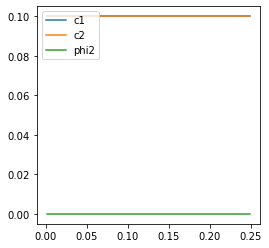

In [93]:
viewer = Viewer(vars=(c1, c2, phi2))

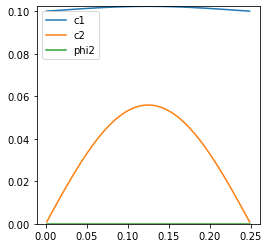

<Figure size 432x288 with 0 Axes>

In [94]:
newtonC1 = []
newtonC2 = []
newtonPhi2 = []

for step in range(100):
    c1.updateOld()
    c2.updateOld()
    phi2.updateOld()
    deltaC1.updateOld()
    deltaC2.updateOld()
    deltaPhi2.updateOld()
    for sweep in range(4):
        res_c1 = newton_eqC1.sweep(dt=1)
        res_c2 = newton_eqC2.sweep(dt=1)
        res_phi2 = newton_eqPhi2.sweep(dt=1)
        
        c1.value = c1.value + deltaC1.value
        c2.value = c2.value + deltaC2.value
        phi2.value = phi2.value + deltaPhi2.value
        
        newtonC1.append([sweep,res_c1,max(abs(deltaC1))])
        newtonC2.append([sweep,res_c2,max(abs(deltaC2))])
        newtonPhi2.append([sweep,res_phi2,max(abs(deltaPhi2))])
    viewer.plot()